deepar

# Load data

In [40]:
import pandas as pd
import numpy as np
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
all = pd.concat([train, test], axis = 0)
transactions = pd.read_csv("data/transactions.csv")
holiday_events = pd.read_csv("data/holidays_events.csv")
stores = pd.read_csv("data/stores.csv")
oil = pd.read_csv("data/oil.csv")

# feature engineering

In [41]:
# https://www.kaggle.com/code/ekrembayar/holiday_events-events-data-manipulation-time-features/notebook
# Deal multiple holiday
# 확인 후 리팩토링 필요

tr1 = holiday_events[(holiday_events.type == "Holiday") & (holiday_events.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holiday_events[(holiday_events.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holiday_events = holiday_events[(holiday_events.transferred == False) & (holiday_events.type != "Transfer")].drop("transferred", axis = 1)
holiday_events = holiday_events.append(tr).reset_index(drop = True)


# Additional Holidays
# ------------------------------------------------------
holiday_events["description"] = holiday_events["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holiday_events["type"] = np.where(holiday_events["type"] == "Additional", "Holiday", holiday_events["type"])

# Bridge Holidays
# ------------------------------------------------------
holiday_events["description"] = holiday_events["description"].str.replace("Puente ", "")
holiday_events["type"] = np.where(holiday_events["type"] == "Bridge", "Holiday", holiday_events["type"])

 
# Work Day Holidays, that is meant to payback the Bridge.
# ------------------------------------------------------
work_day = holiday_events[holiday_events.type == "Work Day"]  
holiday_events = holiday_events[holiday_events.type != "Work Day"]  


# Split
# ------------------------------------------------------

# Events are national
events = holiday_events[holiday_events.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holiday_events = holiday_events[holiday_events.type != "Event"].drop("type", axis = 1)
regional = holiday_events[holiday_events.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holiday_events[holiday_events.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holiday_events[holiday_events.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

# Merge
holiday_events = pd.concat([events, regional, national, local], axis = 0).reset_index(drop = True)

# convert datetime to str
# some additional date features
date_info = pd.DataFrame({"date": pd.date_range(start=all["date"].min(), end=all["date"].max())})

date_info["year"] = date_info["date"].dt.year
date_info["month"] = date_info["date"].dt.month
date_info["day"] = date_info["date"].dt.day
date_info["dayofweek"] = date_info["date"].dt.dayofweek
date_info["weekend"] = (date_info["dayofweek"] >= 5).astype(int)
date_info["week"] = date_info["date"].dt.week
date_info["quarter"] = date_info["date"].dt.quarter
date_info["season"] = date_info["month"] % 12 // 3 + 1

date_info["date"] = date_info["date"].astype(str)

/tmp/ipykernel_3733230/3777914067.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  holiday_events = holiday_events.append(tr).reset_index(drop = True)
/tmp/ipykernel_3733230/3777914067.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  holiday_events["description"] = holiday_events["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
/tmp/ipykernel_3733230/3777914067.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  holiday_events["description"] = holiday_events["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
/tmp/ipykernel_3733230/3777914067.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Pl

# make train

In [42]:
all

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0
28509,3029397,2017-08-31,9,PRODUCE,NaN,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


In [43]:
# make train
merged = pd.merge(all, transactions, on=["date", "store_nbr"], how="left")
merged = pd.merge(merged, stores, on=["store_nbr"], how="left")
merged = pd.merge(merged, holiday_events, on=["date", "city", "state"], how="left")
merged = pd.merge(merged, date_info, on=["date"], how="left")
merged = pd.merge(merged, oil, on=["date"], how="left")

# 없는 값은 거래가 발생하지 않은 것으로 가정
merged["transactions"] = merged["transactions"].fillna(0)

In [44]:
# fill na
# TODO: Normal은 0으로 취급될 수 있게 변경 필요
merged["events"] = merged["events"].fillna("Normal")
merged["holiday_regional"] = merged["holiday_regional"].fillna("Normal")
merged["holiday_national"] = merged["holiday_national"].fillna("Normal")
merged["holiday_local"] = merged["holiday_local"].fillna("Normal")

In [45]:
# FIXME: for simplicity
# use only family=AUTOMOTIVE, store_nbr=1
# idx = (merged["family"] == "AUTOMOTIVE") & (merged["store_nbr"] == 1)
# merged = merged[idx]

In [46]:
# make item_id
merged["item_id"] = merged["family"] + "_" + merged["store_nbr"].astype(str)

# separate static and covariates
drop_cols = []
static_cols = ["store_nbr","family","type","cluster", "state", "city"]

static_features = merged[static_cols + ["item_id"]].drop_duplicates()
static_features.set_index("item_id", inplace=True)
merged = merged.drop(columns=drop_cols + static_cols)

merged["date"] = pd.to_datetime(merged["date"], format="%Y-%m-%d")
merged.sort_values(by=["item_id","date"], inplace=True)

In [47]:
# fill na
# TODO: Normal은 0으로 취급될 수 있게 변경 필요
merged["events"] = merged["events"].fillna("Normal")
merged["holiday_regional"] = merged["holiday_regional"].fillna("Normal")
merged["holiday_national"] = merged["holiday_national"].fillna("Normal")
merged["holiday_local"] = merged["holiday_local"].fillna("Normal")
merged["dcoilwtico"] = merged["dcoilwtico"].fillna(method="ffill")
merged["dcoilwtico"] = merged["dcoilwtico"].fillna(method="bfill")

In [48]:
# one hot encoding
categorical_col = ["events", "holiday_regional", "holiday_national", "holiday_local"]
encoded = pd.get_dummies(merged[categorical_col + ["item_id", "date"]], columns=categorical_col)
merged = pd.merge(merged, encoded, on=["item_id", "date"], how="left")
merged.drop(columns=categorical_col, inplace=True)

In [49]:
merged.head()

,id,date,sales,onpromotion,transactions,year,month,day,dayofweek,weekend,week,quarter,season,dcoilwtico,item_id,events_Normal,holiday_regional_Normal,holiday_national_Normal,holiday_local_Normal
0,0,2013-01-01,0.0,0,0.0,2013,1,1,1,0,1,1,1,93.14,AUTOMOTIVE_1,1,1,1,1
1,1782,2013-01-02,2.0,0,2111.0,2013,1,2,2,0,1,1,1,93.14,AUTOMOTIVE_1,1,1,1,1
2,3564,2013-01-03,3.0,0,1833.0,2013,1,3,3,0,1,1,1,92.97,AUTOMOTIVE_1,1,1,1,1
3,5346,2013-01-04,3.0,0,1863.0,2013,1,4,4,0,1,1,1,93.12,AUTOMOTIVE_1,1,1,1,1
4,7128,2013-01-05,5.0,0,1509.0,2013,1,5,5,1,1,1,1,93.12,AUTOMOTIVE_1,1,1,1,1


# Make TimeSeriesDataFrame

In [50]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

timeseries_df = TimeSeriesDataFrame.from_data_frame(
    merged,
    id_column="item_id",
    timestamp_column="date"
)
timeseries_df = timeseries_df.to_regular_index(freq="D")

categorical_col = ["store_nbr", "family", "type", "cluster", "city", "state"]
for col in categorical_col:
    # encoding to number
    static_features[col] = static_features[col].astype("category")

In [51]:
train_data, test_data = timeseries_df.split_by_time(pd.Timestamp("2017-08-16"))

train_data.static_features = static_features
test_data.static_features = static_features

train_data["sales"] = np.log1p(train_data["sales"])

# christmas 등
train_data = train_data.fill_missing_values('pad', value = 0)

In [52]:
known_covariates_cols = list(train_data.columns)
known_covariates_cols.remove("sales")
known_covariates_cols.remove("id")
known_covariates_cols

['onpromotion',
 'transactions',
 'year',
 'month',
 'day',
 'dayofweek',
 'weekend',
 'week',
 'quarter',
 'season',
 'dcoilwtico',
 'events_Normal',
 'holiday_regional_Normal',
 'holiday_national_Normal',
 'holiday_local_Normal']

# Model test
* Autogluontabular

list of features

lag features (observed time series values) based on freq of the data

time features (e.g., day of the week) based on the timestamp of the measurement

lagged known and past covariates (if available)

static features of each item (if available)

In [ ]:
# TODO: lag를 어디까지 보는지?

In [53]:
import autogluon.core as ag
from autogluon.timeseries.splitter import MultiWindowSplitter
splitter = MultiWindowSplitter(num_windows=1)
predictor = TimeSeriesPredictor(known_covariates_names=known_covariates_cols, target="sales", prediction_length=16, validation_splitter=splitter,
                                eval_metric="RMSE", verbosity = 4)
predictor.fit(train_data=train_data,
              hyperparameters={
            "AutoGluonTabular": {"GBM" :{}}
            })

No path specified. Models will be saved in: "AutogluonModels/ag-20230606_105350/"
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': {'AutoGluonTabular': {'GBM': {}}},
 'prediction_length': 16,
 'random_seed': None,
 'target': 'sales',
 'time_limit': None}
Provided training data set with 3008016 rows, 1782 items (item = single time series). Average time series length is 1688.0.
Training artifacts will be saved to: /home/mysunk/PJT/automl_study/msun/AutogluonModels/ag-20230606_105350
Beginning AutoGluon training with TimeSeriesLearner 
AutoGluon will save models to AutogluonModels/ag-20230606_105350/
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.


KeyboardInterrupt: 

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: AutoGluonTabular
Model not specified in predict, will default to the model with the best validation score: AutoGluonTabular


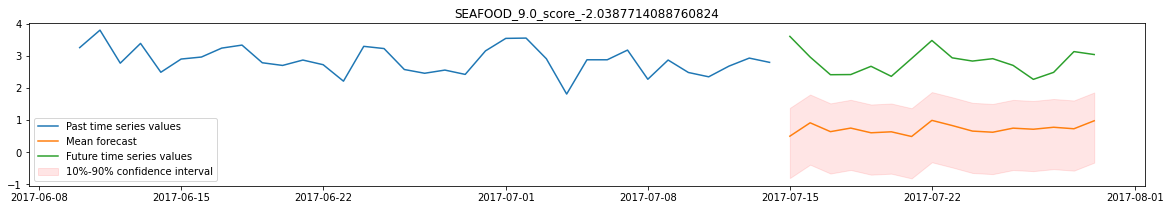

In [ ]:
item_id = "SEAFOOD_9"
idx = train_data.index.get_level_values(0) == item_id
valid_data = train_data[idx]

# pred validation
result = predictor.predict(valid_data[:-32], known_covariates=valid_data[known_covariates_cols][-32:-16])
eval_score = predictor.evaluate(valid_data[-32-16:-16], metric = "RMSE")

# plot validation
# plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))

y_past = valid_data.loc[item_id][:-32]["sales"]
y_pred = result.loc[item_id]
y_test = valid_data.loc[item_id][-32:-16]["sales"]

plt.plot(y_past[-7*5:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"].values, y_pred["0.9"].values, color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()
plt.title(item_id + "_score_" +str(eval_score))
plt.show()